### Set up

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
PATH = '../../fastai/courses/dl1/data/dogscats/'
sz = 224
arch=resnet34
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

### Simple training, 2 epochs

In [3]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [4]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.046317   0.025963   0.992188  
    1      0.040555   0.026857   0.991699                     



[0.026856974, 0.99169921875]

In [5]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [6]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [7]:
from sklearn.metrics import confusion_matrix

[[991   9]
 [  7 993]]


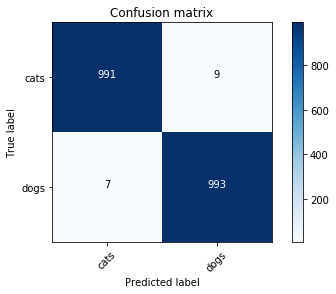

In [9]:
y = data.val_y
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

### Data Augmentation and LR annealing, 3 epochs

In [3]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [4]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████  | 291/360 [00:04<00:01, 61.93it/s, loss=0.398] 


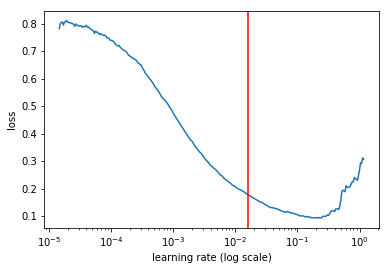

In [5]:
import matplotlib.pyplot as plt
learn.sched.plot()
plt.axvline(x=1.6e-2, color="red");

In [6]:
learn.fit(1.6e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.049547   0.025796   0.990723  



[0.025795702, 0.99072265625]

In [7]:
learn.precompute=False
learn.fit(1.6e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.050279   0.023681   0.991699  
    1      0.044692   0.025156   0.991699                     
    2      0.034418   0.02373    0.992188                     



[0.023730122, 0.9921875]

[[991   9]
 [  7 993]]


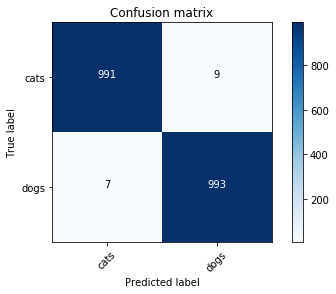

In [8]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

#### TTA

In [10]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.9915

### Fine tuning, 7 epochs

In [11]:
learn.unfreeze()
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 64%|██████▎   | 229/360 [03:26<01:58,  1.11it/s, loss=0.214] 

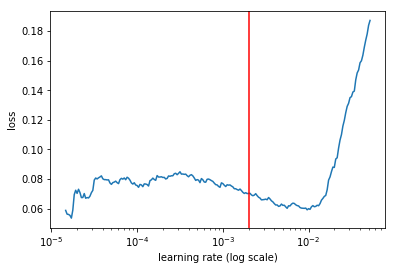

In [21]:
learn.sched.plot()
plt.axvline(x=2e-3, color="red");

In [22]:
learn.save('224_lastlayer')

In [24]:
learn.load('224_lastlayer')

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1.6e-2, 1)
learn.precompute=False
learn.load('224_lastlayer')
learn.unfreeze()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.04632    0.02876    0.989258  



In [28]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.044187   0.022855   0.993652  
    1      0.038889   0.018417   0.994629                     
    2      0.0349     0.017674   0.993164                     



[0.017673668, 0.9931640625]

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1.6e-2, 1)
learn.precompute=False
learn.load('224_lastlayer')
learn.unfreeze()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.045431   0.022102   0.991699  



In [30]:
lr=np.array([2e-5,2e-4,2e-3])
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.061601   0.028167   0.991211  
    1      0.05427    0.024382   0.991699                     
    2      0.053687   0.023506   0.993164                     



[0.023505576, 0.9931640625]

In [32]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.045097   0.022121   0.993164  
    1      0.042951   0.020188   0.994141                     
    2      0.037586   0.020444   0.992676                     



[0.02044399, 0.99267578125]

[[992   8]
 [  7 993]]


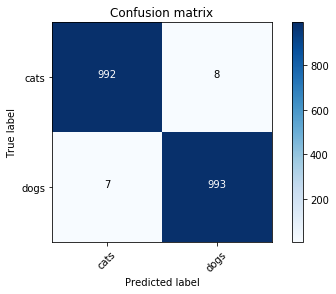

In [33]:
#learn.save('224_all')
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])
cm = confusion_matrix(data.val_y, preds)
plot_confusion_matrix(cm, data.classes)

#### TTA

In [34]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.994